## Final Project Submission - Determining the best houses to flip for a profit

Please fill out:
* Student name: Alec Hing
* Student pace: FLEX
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Obtaining Data and Importing Libraries

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
data = pd.read_csv('data/kc_house_data.csv')

from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from scipy.stats import zscore
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#Getting Column Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
useful_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
                 'grade', 'yr_built', 'yr_renovated']

In [5]:
#Removing Columns not needed
useful_data = data[useful_columns]
useful_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         21597 non-null  float64
 1   bedrooms      21597 non-null  int64  
 2   bathrooms     21597 non-null  float64
 3   sqft_living   21597 non-null  int64  
 4   sqft_lot      21597 non-null  int64  
 5   floors        21597 non-null  float64
 6   waterfront    19221 non-null  object 
 7   view          21534 non-null  object 
 8   condition     21597 non-null  object 
 9   grade         21597 non-null  object 
 10  yr_built      21597 non-null  int64  
 11  yr_renovated  17755 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 2.0+ MB


# Scrubbing and Cleaning Data

In [7]:
# Checking for NaNs
useful_data.isna().sum()

price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront      2376
view              63
condition          0
grade              0
yr_built           0
yr_renovated    3842
dtype: int64

In [8]:
# Investigating unique values
useful_data['waterfront'].unique()
#useful_data['yr_renovated'].unique()

array([nan, 'NO', 'YES'], dtype=object)

In [9]:
useful_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,17755.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1970.999676,83.636778
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,29.375234,399.946414
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1951.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1975.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,1997.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,2015.000000,2015.000000


In [10]:
# Replace NaNs in Waterfront with "No". Couldn't replace NaNs in a sliced 
# column. Assuming NaN means no waterfront
data['waterfront'] = data['waterfront'].fillna("NO")
useful_data['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [11]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [12]:
#Check View column values
useful_data["view"].unique()

array(['NONE', nan, 'GOOD', 'EXCELLENT', 'AVERAGE', 'FAIR'], dtype=object)

In [13]:
useful_data['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [14]:
#Assuming NaN values mean no view
data['view'] = data['view'].fillna('NONE')
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [15]:
#Check yr_renovated values/ Decided to no longer use this column
data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [16]:
data['yr_renovated'].isna().sum()

3842

In [17]:
useful_data = data[useful_columns]
useful_data.isna().sum()

price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
grade              0
yr_built           0
yr_renovated    3842
dtype: int64

In [18]:
# Checking to see what data looks like that have NaNs in yr_renovated
# useful_data[useful_data['yr_renovated'].isna()].head()

In [19]:
# Assuming NaN values mean home was never renovated so this will be changed to 
# 0 to represent never renovated 
# Changing NaN to 0's created 0's again after taking the log of it
data['yr_renovated'] = data['yr_renovated'].fillna(0)
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [20]:
# Prepping yr_renovated to be turned into categorical data
# Resource to get renovation info: 
# https://www.carneyproperties.com/how-often-should-you-remodel-your-home/
# The average time frame will be determined based on the condition of your property. 
# If your home is still in good condition, renovation should be done every 15 to 20 years.
# Turning Years in from yr_renovated into Yes to represent renovations were done
data['renovations_done'] = data['yr_renovated'].map(
    lambda x: 'Yes' if x>0 else 'No')
#data.head(10)
data.renovations_done.value_counts

<bound method IndexOpsMixin.value_counts of 0         No
1        Yes
2         No
3         No
4         No
        ... 
21592     No
21593     No
21594     No
21595     No
21596     No
Name: renovations_done, Length: 21597, dtype: object>

In [21]:
useful_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
                 'grade', 'yr_built', 'renovations_done']
useful_data = data[useful_columns]
useful_data.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
yr_built            0
renovations_done    0
dtype: int64

## Baseline Model

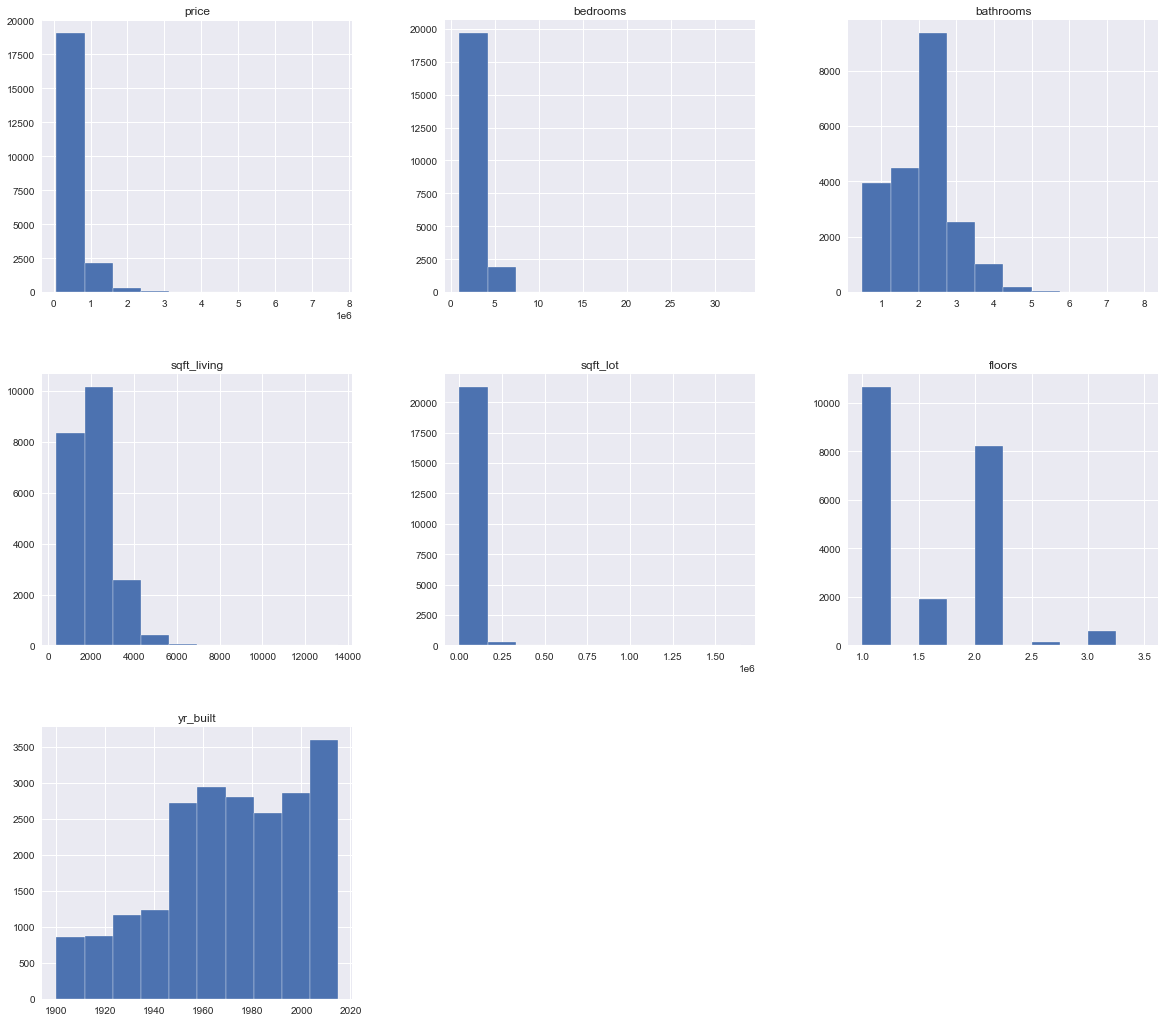

In [22]:
# Looking at histograms before changing any data
useful_data.hist(figsize = (20,18));
plt.savefig(fname='./images/baseline_model.png', facecolor='white')

In [23]:
# Not much of a normal distribution among these graphs. Just sligtly in
# sqft_living and bathrooms

### Checking for linearity

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


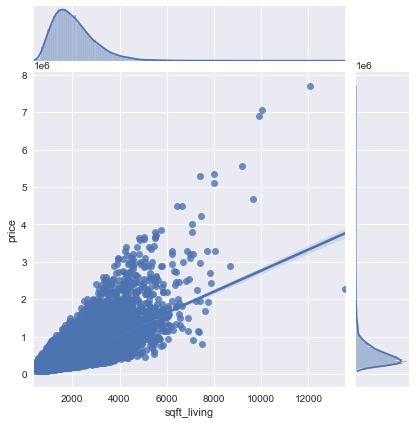

In [24]:
# Checking for linearity 
sns.jointplot('sqft_living', 'price', data=useful_data, kind='reg' );

In [25]:
# There is some linearity here but a lot of it is concentrated in one spot
# with outliers in the higher ranges of sqft_living

### Running linear model with Price as the target variable in statsmodel

In [26]:
continuous = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 
             'sqft_lot', 'floors', 'yr_built']
categoricals = ['waterfront', 'view', 'condition', 'grade', 'renovations_done']

useful_data_cont = useful_data[continuous]
useful_data_cat = useful_data[categoricals]

In [27]:
useful_data_ohe = pd.get_dummies(useful_data_cat, drop_first = True)

In [28]:
# Combining categorical and continuous 
baseline_data = pd.concat([useful_data_cont, useful_data_ohe], axis = 1)
baseline_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'yr_built', 'waterfront_YES', 'view_EXCELLENT', 'view_FAIR',
       'view_GOOD', 'view_NONE', 'condition_Fair', 'condition_Good',
       'condition_Poor', 'condition_Very Good', 'grade_11 Excellent',
       'grade_12 Luxury', 'grade_13 Mansion', 'grade_3 Poor', 'grade_4 Low',
       'grade_5 Fair', 'grade_6 Low Average', 'grade_7 Average',
       'grade_8 Good', 'grade_9 Better', 'renovations_done_Yes'],
      dtype='object')

In [29]:
X = baseline_data.drop('price', axis=1)
y = baseline_data['price']

In [30]:
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     1774.
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:41:13   Log-Likelihood:            -2.9504e+05
No. Observations:               21597   AIC:                         5.901e+05
Df Residuals:                   21570   BIC:                         5.904e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.865e+06   1.34e+05     51.284      0.000     6.6e+06    7.13e+06
bedrooms             -2.461e+04   1994.564    -12.338      0.000   -2.85e+04   -2.07e+04
bathrooms             5.027e+04   3340.512     15.050      0.000    4.37e+04    5.68e+04
sqft_living            136.0276      3.279     41.482      0.000     129.600     142.455
sqft_lot                -0.2668      0.035     -7.612      0.000      -0.335      -0.198
floors                3.217e+04   3339.714      9.632      0.000    2.56e+04    3.87e+04
yr_built             -3203.4955     68.418    -46.822      0.000   -3337.600   -3069.391
waterfront_YES        5.233e+05    2.1e+04     24.866      0.000    4.82e+05    5.65e+05
view_EXCELLENT        2.005e+05   1.57e+04     12.744      0.000     1.7e+05    2.31e+05
view_FAIR              6.63e+04   1.33e+04      4.999      0.000    4.03e+04    9.23e+04
view_GOOD             5.772e+04   1.14e+04      5.050      0.000    3.53e+04    8.01e+04
view_NONE             -5.72e+04   7028.463     -8.138      0.000    -7.1e+04   -4.34e+04
condition_Fair       -2.625e+04   1.62e+04     -1.620      0.105    -5.8e+04    5517.152
condition_Good        1.853e+04   3541.497      5.232      0.000    1.16e+04    2.55e+04
condition_Poor       -3.966e+04   3.89e+04     -1.019      0.308   -1.16e+05    3.66e+04
condition_Very Good   5.962e+04   5709.639     10.442      0.000    4.84e+04    7.08e+04
grade_11 Excellent     2.68e+05   1.23e+04     21.775      0.000    2.44e+05    2.92e+05
grade_12 Luxury       7.369e+05   2.35e+04     31.325      0.000    6.91e+05    7.83e+05
grade_13 Mansion      1.925e+06   5.89e+04     32.659      0.000    1.81e+06    2.04e+06
grade_3 Poor         -5.672e+05   2.08e+05     -2.729      0.006   -9.75e+05    -1.6e+05
grade_4 Low          -5.356e+05   4.12e+04    -12.991      0.000   -6.16e+05   -4.55e+05
grade_5 Fair         -5.468e+05   1.64e+04    -33.315      0.000   -5.79e+05   -5.15e+05
grade_6 Low Average   -4.95e+05   1.01e+04    -48.920      0.000   -5.15e+05   -4.75e+05
grade_7 Average      -4.132e+05   8314.319    -49.703      0.000    -4.3e+05   -3.97e+05
grade_8 Good         -3.238e+05   7610.185    -42.548      0.000   -3.39e+05   -3.09e+05
grade_9 Better       -1.815e+05   7593.165    -23.904      0.000   -1.96e+05   -1.67e+05
renovations_done_Yes   4.23e+04   8202.486      5.156      0.000    2.62e+04    5.84e+04
==============================================================================
Omnibus:                    12402.284   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           458758.768
Skew:                           2.155   Prob(JB):                         0.00
Kurtosis:                      25.164   Cond. No.                     6.49e+06
==================

In [31]:
baseline_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,waterfront_YES,view_EXCELLENT,view_FAIR,...,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,renovations_done_Yes
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1970.999676,0.006760,0.014678,0.015280,...,0.004121,0.000602,0.000046,0.001250,0.011205,0.094365,0.415521,0.280826,0.121082,0.034449
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,29.375234,0.081944,0.120263,0.122667,...,0.064064,0.024528,0.006805,0.035337,0.105263,0.292343,0.492823,0.449413,0.326230,0.182384
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1951.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1975.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,1997.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,2015.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Check for multicollinearity

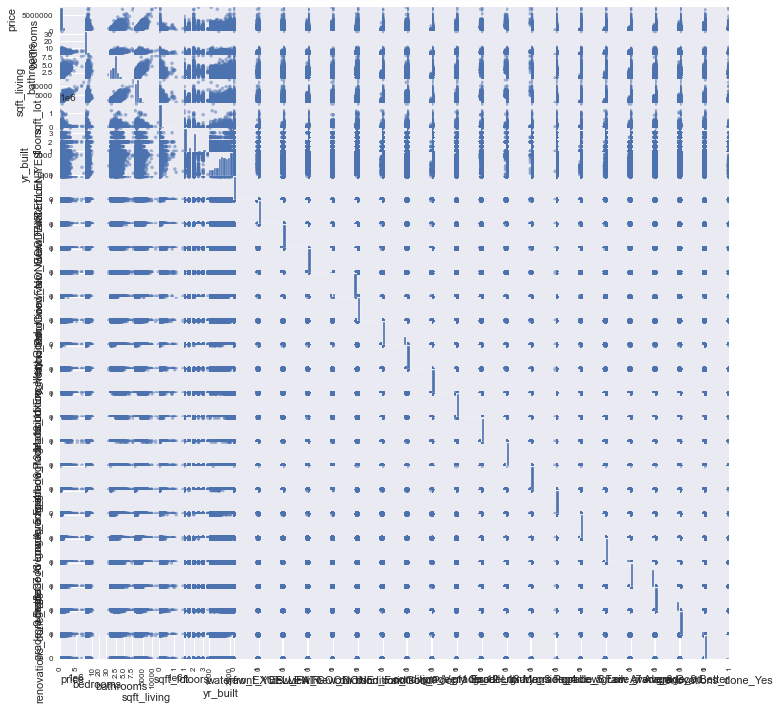

In [32]:
#Creating a scatter matrix
pd.plotting.scatter_matrix(baseline_data, figsize=[12,12]);

In [33]:
check_corr =  baseline_data.drop('price', axis=1)
corr = check_corr.corr()

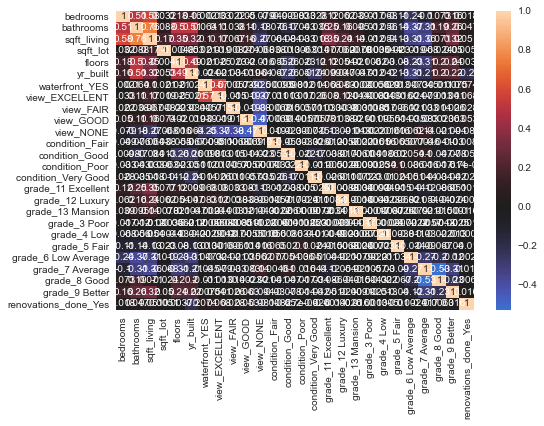

In [34]:
#abs(baseline_data.corr() > 0.75 )
#dont need to use categorical data
sns.heatmap(corr, center=0, annot=True);

In [35]:
# Most columns show litte promise to add predictive power towards price.
# Because of this there isn't a high concern for high correlation
# The best predicators with fairly high correlation are bedrooms, bathrooms,
# and sqft_living
# Remove either bedrooms or bathrooms

## Removing a high correlated variable

In [36]:
X = baseline_data.drop(['price', 'bedrooms'], axis=1)
y = baseline_data['price']

In [37]:
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1826.
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:42:15   Log-Likelihood:            -2.9512e+05
No. Observations:               21597   AIC:                         5.903e+05
Df Residuals:                   21571   BIC:                         5.905e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.715e+06   1.34e+05     50.194      0.000    6.45e+06    6.98e+06
bathrooms             4.289e+04   3297.887     13.004      0.000    3.64e+04    4.94e+04
sqft_living            119.7458      3.012     39.751      0.000     113.841     125.650
sqft_lot                -0.2365      0.035     -6.740      0.000      -0.305      -0.168
floors                3.358e+04   3349.440     10.025      0.000     2.7e+04    4.01e+04
yr_built             -3136.7249     68.443    -45.830      0.000   -3270.877   -3002.572
waterfront_YES        5.325e+05   2.11e+04     25.231      0.000    4.91e+05    5.74e+05
view_EXCELLENT        2.032e+05   1.58e+04     12.867      0.000    1.72e+05    2.34e+05
view_FAIR             6.701e+04   1.33e+04      5.035      0.000    4.09e+04    9.31e+04
view_GOOD              5.96e+04   1.15e+04      5.197      0.000    3.71e+04    8.21e+04
view_NONE             -6.12e+04   7045.554     -8.686      0.000    -7.5e+04   -4.74e+04
condition_Fair       -2.628e+04   1.63e+04     -1.616      0.106   -5.82e+04    5603.142
condition_Good        1.709e+04   3551.956      4.811      0.000    1.01e+04     2.4e+04
condition_Poor       -3.734e+04    3.9e+04     -0.957      0.339   -1.14e+05    3.92e+04
condition_Very Good   5.853e+04   5728.936     10.217      0.000    4.73e+04    6.98e+04
grade_11 Excellent    2.782e+05   1.23e+04     22.571      0.000    2.54e+05    3.02e+05
grade_12 Luxury       7.639e+05   2.35e+04     32.500      0.000    7.18e+05     8.1e+05
grade_13 Mansion       1.98e+06    5.9e+04     33.577      0.000    1.86e+06     2.1e+06
grade_3 Poor         -5.524e+05   2.09e+05     -2.649      0.008   -9.61e+05   -1.44e+05
grade_4 Low           -5.34e+05   4.14e+04    -12.908      0.000   -6.15e+05   -4.53e+05
grade_5 Fair         -5.584e+05   1.64e+04    -33.957      0.000   -5.91e+05   -5.26e+05
grade_6 Low Average  -5.095e+05   1.01e+04    -50.528      0.000   -5.29e+05    -4.9e+05
grade_7 Average      -4.311e+05   8215.770    -52.475      0.000   -4.47e+05   -4.15e+05
grade_8 Good         -3.375e+05   7555.401    -44.667      0.000   -3.52e+05   -3.23e+05
grade_9 Better       -1.904e+05   7585.214    -25.103      0.000   -2.05e+05   -1.76e+05
renovations_done_Yes   4.61e+04   8225.370      5.605      0.000       3e+04    6.22e+04
==============================================================================
Omnibus:                    12584.548   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           483816.832
Skew:                           2.190   Prob(JB):                         0.00
Kurtosis:                      25.770   Cond. No.                     6.49e+06
==============================================================================

Notes:
[1] Standard Errors 

In [ ]:
# Rsquared value dropped a little by removing bedrooms.

## Investigating Homoscedasticity

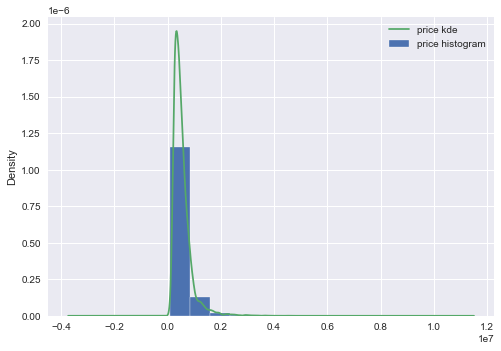

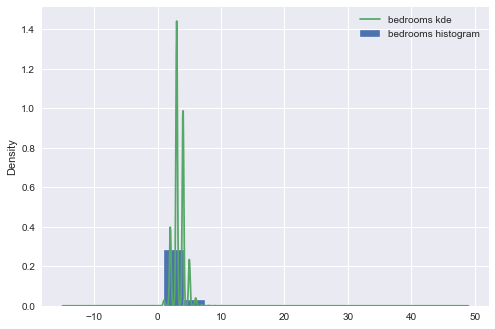

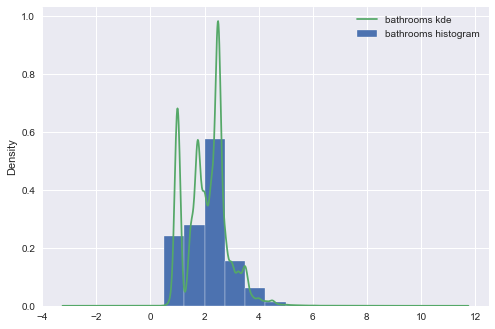

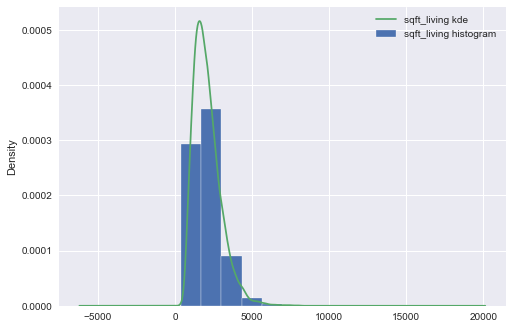

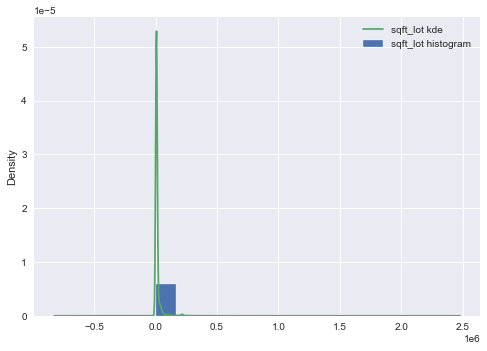

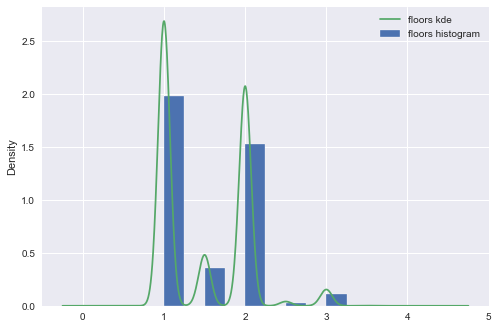

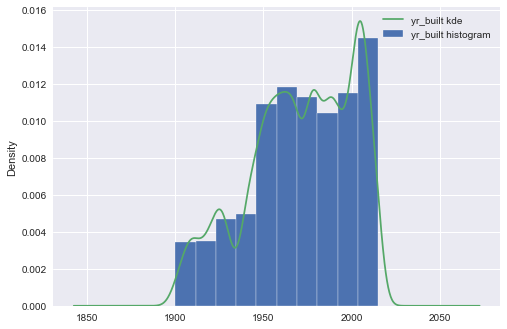

In [94]:
# Checking distribution by creating a histogram with kde for all variables
for column in useful_data_cont:
    useful_data_cont[column].plot.hist(density=True, label = column+' histogram')
    useful_data_cont[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

In [60]:
# No variable is perfectly normal in distribution

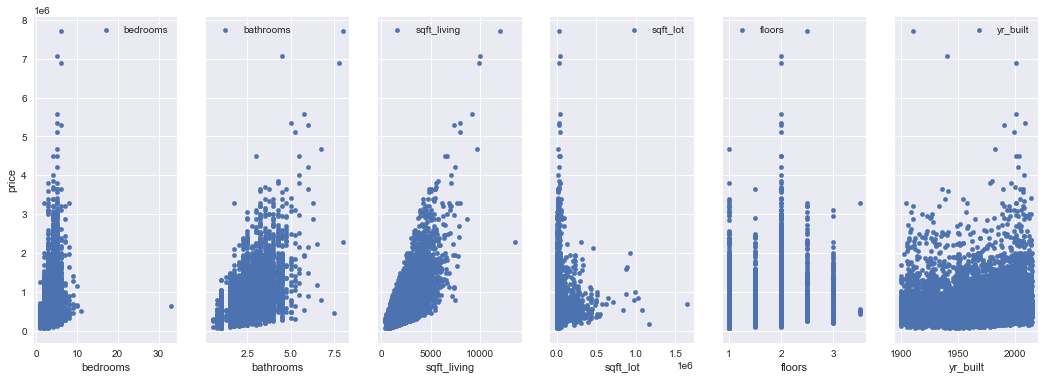

In [95]:
# Test for linearity assumptions
fig, axs = plt.subplots(1, 6, sharey=True, figsize=(18, 6))
for idx, channel in enumerate(['bedrooms', 'bathrooms','sqft_living',
                              'sqft_lot', 'floors', 'yr_built']):
    data.plot(kind='scatter', x=channel, y='price', ax=axs[idx], label=channel)
plt.legend()
plt.show()

In [62]:
# Sqft_living and bathrooms seem to have a decent linear relationship with 
# price.

In [96]:
# Regression with sqft_living as predictor
f = 'price~sqft_living'
model = smf.ols(formula=f, data= baseline_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:27:20   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

   sqft_living
0          370
1        13540
0    5.993042e+04
1    3.758896e+06
dtype: float64


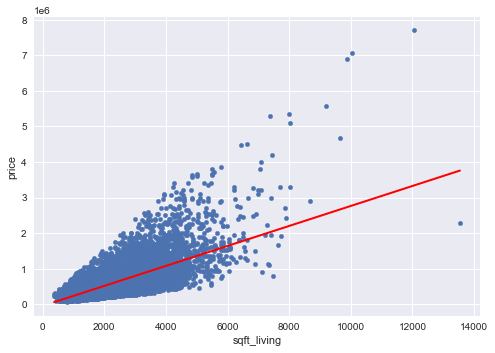

<Figure size 576x396 with 0 Axes>

In [102]:
# A DataFrame with the minimum and maximum values of sqft_living
X_new = pd.DataFrame({'sqft_living': [useful_data_cont.sqft_living.min(), 
                                      useful_data_cont.sqft_living.max()]})
print(X_new.head())

# Making predictions for those x values and storing them
preds = model.predict(X_new)
print (preds)

# Plotting the observed data and the least squares line
data.plot(kind='scatter', x='sqft_living', y='price')
plt.plot(X_new, preds, c='red', linewidth=2)
plt.show()


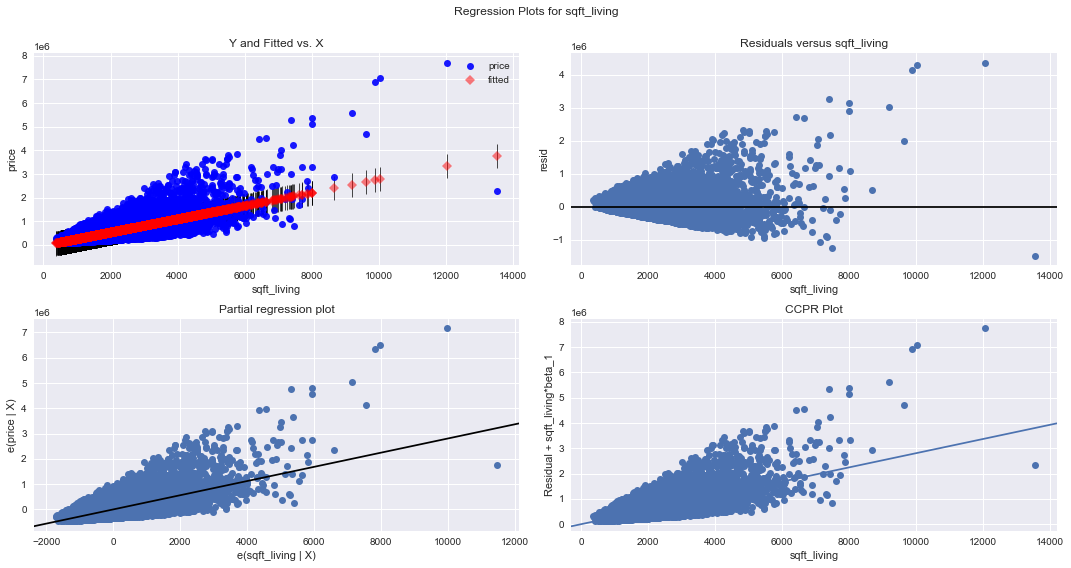

<Figure size 576x396 with 0 Axes>

In [100]:
# Visualizing the error term for variance and heteroscedasticity
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()


In [66]:
# The graphs are cone shaped indicating heteroscedasticity.

In [67]:
# Rsquared value of baseline data is 0.681 
# The coefficients with a P value of 0.05 or greater are condition_fair and
# condition_Poor. Removing these columns could provide improvements to model


## Removing Coefficients with a P Value of 0.05 or greater and those with a high correlation to Price

In [68]:
# removing condition_fair, condition_poor, and 'bedrooms'
y_drop = baseline_data['price']
X_drop = baseline_data.drop(['condition_Fair', 'condition_Poor', 'price', 
                             'bedrooms'], axis=1)
X_drop.columns

Index(['bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'yr_built',
       'waterfront_YES', 'view_EXCELLENT', 'view_FAIR', 'view_GOOD',
       'view_NONE', 'condition_Good', 'condition_Very Good',
       'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion',
       'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', 'grade_6 Low Average',
       'grade_7 Average', 'grade_8 Good', 'grade_9 Better',
       'renovations_done_Yes'],
      dtype='object')

In [69]:
# Rsquare after removal 0.679
X_int_drop = sm.add_constant(X_drop)
model = sm.OLS(y_drop,X_int_drop).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1984.
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:14:45   Log-Likelihood:            -2.9512e+05
No. Observations:               21597   AIC:                         5.903e+05
Df Residuals:                   21573   BIC:                         5.905e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.699e+06   1.34e+05     50.176      0.000    6.44e+06    6.96e+06
bathrooms              4.29e+04   3297.988     13.008      0.000    3.64e+04    4.94e+04
sqft_living            119.7659      3.012     39.757      0.000     113.861     125.671
sqft_lot                -0.2392      0.035     -6.826      0.000      -0.308      -0.171
floors                3.368e+04   3348.901     10.057      0.000    2.71e+04    4.02e+04
yr_built             -3128.9974     68.317    -45.801      0.000   -3262.904   -2995.091
waterfront_YES        5.323e+05   2.11e+04     25.220      0.000    4.91e+05    5.74e+05
view_EXCELLENT         2.03e+05   1.58e+04     12.856      0.000    1.72e+05    2.34e+05
view_FAIR              6.69e+04   1.33e+04      5.027      0.000    4.08e+04     9.3e+04
view_GOOD             5.953e+04   1.15e+04      5.190      0.000     3.7e+04     8.2e+04
view_NONE            -6.133e+04   7045.450     -8.704      0.000   -7.51e+04   -4.75e+04
condition_Good        1.775e+04   3534.016      5.023      0.000    1.08e+04    2.47e+04
condition_Very Good   5.929e+04   5714.443     10.376      0.000    4.81e+04    7.05e+04
grade_11 Excellent    2.782e+05   1.23e+04     22.573      0.000    2.54e+05    3.02e+05
grade_12 Luxury        7.64e+05   2.35e+04     32.501      0.000    7.18e+05     8.1e+05
grade_13 Mansion       1.98e+06    5.9e+04     33.576      0.000    1.86e+06     2.1e+06
grade_3 Poor         -5.523e+05   2.09e+05     -2.648      0.008   -9.61e+05   -1.43e+05
grade_4 Low          -5.388e+05   4.13e+04    -13.049      0.000    -6.2e+05   -4.58e+05
grade_5 Fair          -5.61e+05   1.64e+04    -34.277      0.000   -5.93e+05   -5.29e+05
grade_6 Low Average  -5.101e+05   1.01e+04    -50.616      0.000    -5.3e+05    -4.9e+05
grade_7 Average      -4.312e+05   8215.946    -52.483      0.000   -4.47e+05   -4.15e+05
grade_8 Good         -3.375e+05   7555.619    -44.666      0.000   -3.52e+05   -3.23e+05
grade_9 Better       -1.904e+05   7585.451    -25.101      0.000   -2.05e+05   -1.76e+05
renovations_done_Yes  4.655e+04   8222.064      5.662      0.000    3.04e+04    6.27e+04
==============================================================================
Omnibus:                    12577.084   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           483103.717
Skew:                           2.188   Prob(JB):                         0.00
Kurtosis:                      25.753   Cond. No.                     6.49e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.49e+06. This might indicate that there are
strong multicollinearity o

## Check normality assumptions by creating a QQ Plot

<ipython-input-70-7615324a6bbc>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


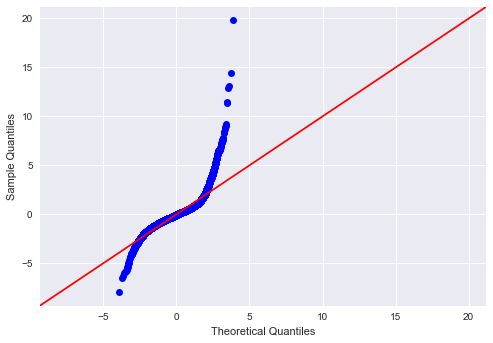

In [70]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [71]:
# Due to the outliers, it is safe to say this is violating normality 
# assumptions.

## Removing Outliers using Standard Deviation 

In [72]:
# Check skewness - 4.023 means a postively skewed
print(baseline_data['price'].skew())

4.023364652271239


In [73]:
# Storing baseline STD and Mean
price_std = baseline_data.price.std()
price_mean = baseline_data.price.mean()
baseline_data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [74]:
# Removing outliers outside of 3 STDs of Price with Capping
baseline_data_trim = baseline_data.copy() 
index = baseline_data_trim[(baseline_data_trim['price'] >= 
                            price_mean+3*price_std)].index
baseline_data_trim.drop(index, inplace = True)
baseline_data_trim['price'].describe()

count    2.119100e+04
mean     5.070103e+05
std      2.594622e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.470000e+05
75%      6.276500e+05
max      1.640000e+06
Name: price, dtype: float64

In [75]:
# Recheck skewness - 1.389 is much better than it was before (3 std)
# 0.947 with 2STds
print(baseline_data_trim['price'].skew())

1.3892777400843523


In [76]:
X_trim = baseline_data_trim.drop('price', axis=1)
y_trim = baseline_data_trim['price']

In [77]:
# Rquared of 3 STDs is 0.630
# Rquared of 2 STDs is 0.598
X_int_trim = sm.add_constant(X_trim)
model = sm.OLS(y_trim,X_int_trim).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     1445.
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:14:45   Log-Likelihood:            -2.8369e+05
No. Observations:               21191   AIC:                         5.674e+05
Df Residuals:                   21165   BIC:                         5.676e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.346e+06   1.04e+05     61.232      0.000    6.14e+06    6.55e+06
bedrooms             -1.456e+04   1543.061     -9.438      0.000   -1.76e+04   -1.15e+04
bathrooms             3.699e+04   2600.969     14.222      0.000    3.19e+04    4.21e+04
sqft_living             94.8098      2.607     36.361      0.000      89.699      99.921
sqft_lot                -0.0897      0.028     -3.252      0.001      -0.144      -0.036
floors                3.532e+04   2576.795     13.707      0.000    3.03e+04    4.04e+04
yr_built             -2921.9291     52.981    -55.151      0.000   -3025.775   -2818.083
waterfront_YES        1.506e+05   2.03e+04      7.427      0.000    1.11e+05     1.9e+05
view_EXCELLENT        1.189e+05   1.33e+04      8.945      0.000    9.29e+04    1.45e+05
view_FAIR             3.539e+04   1.04e+04      3.387      0.001    1.49e+04    5.59e+04
view_GOOD             4.266e+04   9124.433      4.676      0.000    2.48e+04    6.05e+04
view_NONE            -6.085e+04   5478.817    -11.106      0.000   -7.16e+04   -5.01e+04
condition_Fair       -3.962e+04   1.24e+04     -3.204      0.001   -6.38e+04   -1.54e+04
condition_Good        1.374e+04   2716.052      5.057      0.000    8412.275    1.91e+04
condition_Poor       -2.496e+04   2.96e+04     -0.844      0.399    -8.3e+04     3.3e+04
condition_Very Good   5.174e+04   4400.665     11.757      0.000    4.31e+04    6.04e+04
grade_11 Excellent    1.249e+05   1.08e+04     11.615      0.000    1.04e+05    1.46e+05
grade_12 Luxury       2.686e+05   2.85e+04      9.420      0.000    2.13e+05    3.25e+05
grade_13 Mansion     -7.139e-09   8.86e-10     -8.057      0.000   -8.88e-09    -5.4e-09
grade_3 Poor         -5.611e+05   1.58e+05     -3.550      0.000   -8.71e+05   -2.51e+05
grade_4 Low          -5.338e+05   3.14e+04    -16.989      0.000   -5.95e+05   -4.72e+05
grade_5 Fair         -5.341e+05   1.26e+04    -42.235      0.000   -5.59e+05   -5.09e+05
grade_6 Low Average  -4.798e+05   7939.865    -60.434      0.000   -4.95e+05   -4.64e+05
grade_7 Average      -3.838e+05   6583.766    -58.300      0.000   -3.97e+05   -3.71e+05
grade_8 Good          -2.77e+05   6046.160    -45.811      0.000   -2.89e+05   -2.65e+05
grade_9 Better       -1.267e+05   6039.658    -20.973      0.000   -1.39e+05   -1.15e+05
renovations_done_Yes  1.851e+04   6442.173      2.874      0.004    5884.674    3.11e+04
==============================================================================
Omnibus:                     3120.290   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9260.773
Skew:                           0.781   Prob(JB):                         0.00
Kurtosis:                       5.837   Cond. No.                     1.09e+16
==================

<ipython-input-78-e44bfca5f537>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


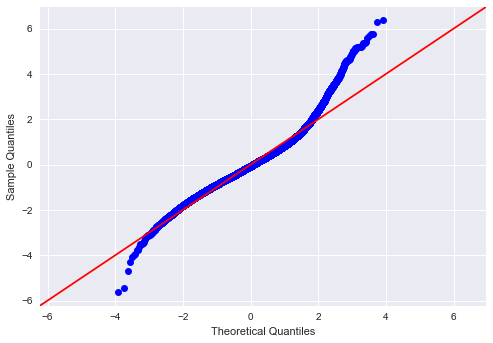

In [78]:
# Check back QQ Plot
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [79]:
# This QQ Plot seems more linear with less outliers.

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


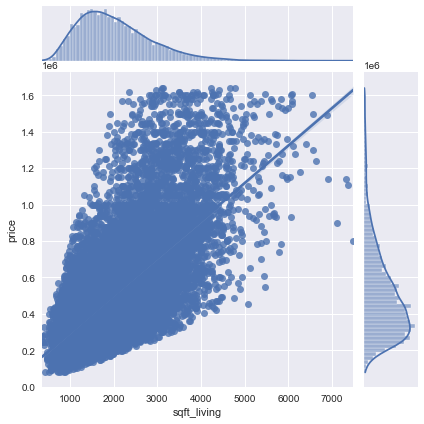

In [80]:
sns.jointplot('sqft_living', 'price', data=baseline_data_trim, kind='reg' );

## Normalizing the Data

In [81]:
useful_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             21597 non-null  float64
 1   bedrooms          21597 non-null  int64  
 2   bathrooms         21597 non-null  float64
 3   sqft_living       21597 non-null  int64  
 4   sqft_lot          21597 non-null  int64  
 5   floors            21597 non-null  float64
 6   waterfront        21597 non-null  object 
 7   view              21597 non-null  object 
 8   condition         21597 non-null  object 
 9   grade             21597 non-null  object 
 10  yr_built          21597 non-null  int64  
 11  renovations_done  21597 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 2.0+ MB


In [82]:
# Sorting columns between categorical and continuous data
continuous = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 
             'sqft_lot', 'floors', 'yr_built']
categoricals = ['waterfront', 'view', 'condition', 'grade', 'renovations_done']

In [83]:
# Continuous features
# Log transform and normalize
data_cont = useful_data[continuous]

#log features
log_names = [f'{column}_log' for column in data_cont.columns]
data_log = np.log(data_cont)
data_log.columns = log_names

# Normalize (Subtracting mean and divide by STD)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

data_log_norm = data_log.apply(normalize)

In [84]:
#Categorical Features
#data_ohe = pd.get_dummies(useful_data[categoricals], prefix=categoricals,
#                        drop_first = True)


In [85]:
#Combining Categorical & Continuous Features
#preprocessed = pd.concat([data_log_norm, data_ohe], axis=1)
preprocessed = data_log_norm
preprocessed.head()

,price_log,bedrooms_log,bathrooms_log,sqft_living_log,sqft_lot_log,floors_log,yr_built_log
0,-1.401998,-0.279718,-1.726509,-1.125556,-0.388430,-0.960852,-0.537409
1,0.279938,-0.279718,0.339653,0.709446,-0.113241,1.006831,-0.674325
2,-1.799430,-1.711611,-1.726509,-2.131893,0.244475,-0.960852,-1.293945
3,0.499698,0.736226,1.072635,0.070674,-0.523914,-0.960852,-0.196338
4,0.178434,-0.279718,0.039555,-0.292725,0.008139,-0.960852,0.547946


In [86]:
preprocessed.isna().sum()

price_log          0
bedrooms_log       0
bathrooms_log      0
sqft_living_log    0
sqft_lot_log       0
floors_log         0
yr_built_log       0
dtype: int64

# Exploring the Data

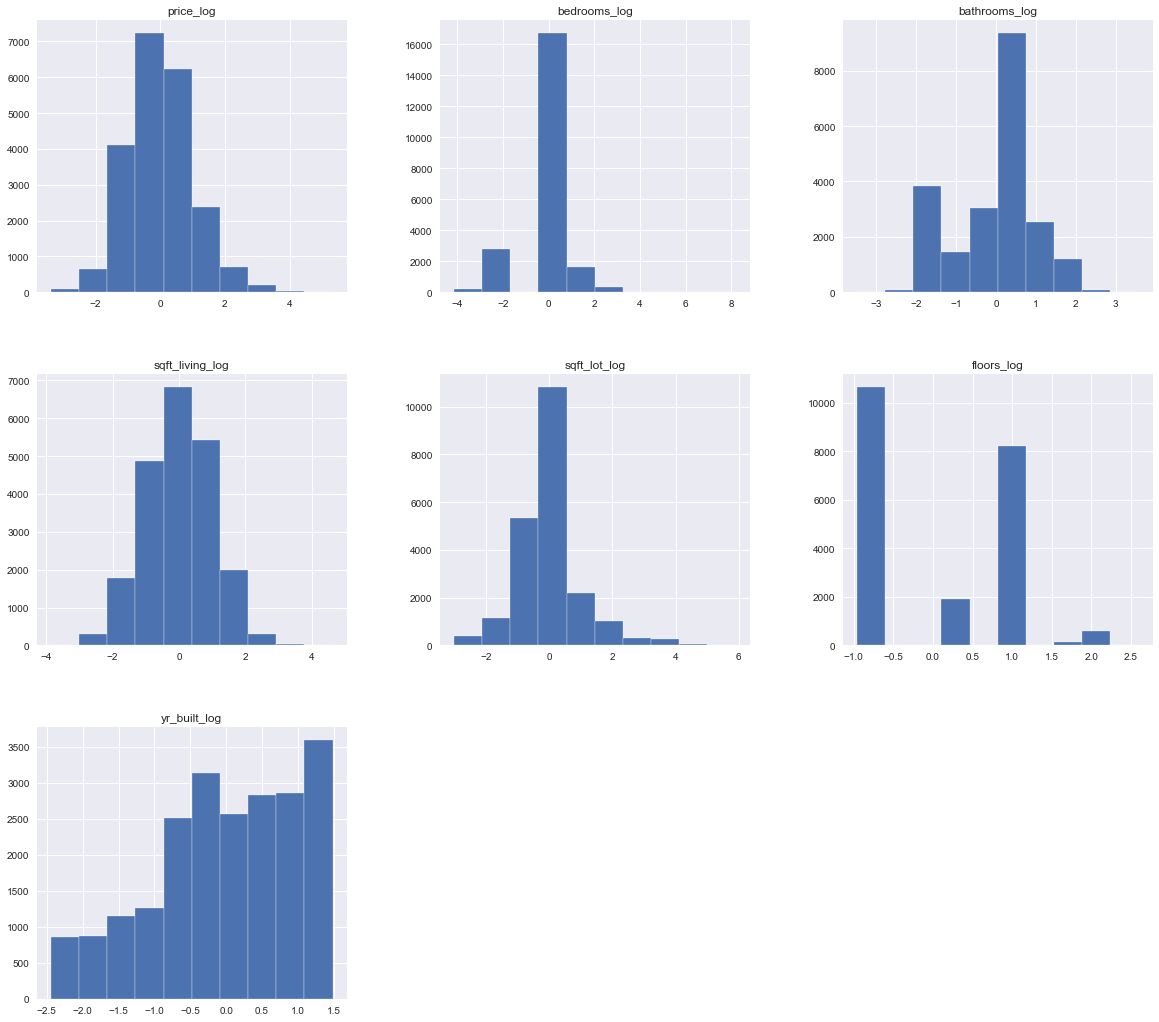

In [87]:
#Plotting histograms for all numeric variables in the dataset
preprocessed.hist(figsize = (20,18));
plt.savefig(fname='./images/normalized.png', facecolor='white')

In [ ]:
# Price_log bathrooms_log and sqft_living_log seem to have a normal 
# distribution

## Check for Linearity

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


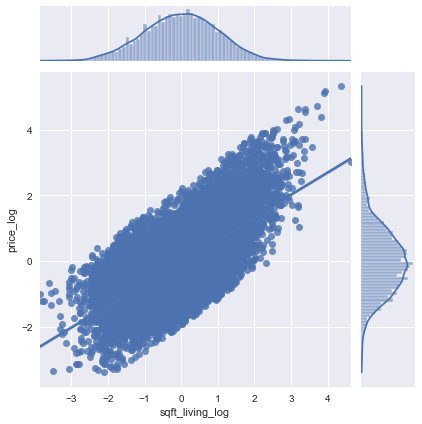

In [78]:
sns.jointplot('sqft_living_log', 'price_log', data=preprocessed, kind='reg' );

In [ ]:
# Price seems to have a linear relationship with sqft_living. Plot looks more
# linaer compared to the first time

# Modeling the Data

## Running linear model with Price as the target variable in statsmodel

In [88]:
X_p = preprocessed.drop('price_log', axis=1)
y_p = preprocessed['price_log']

In [89]:
# OLS Regression Results for normalized log data 
# Rsquared is 0.651
X_int_p = sm.add_constant(X_p)
model = sm.OLS(y_p,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     1550.
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:23:36   Log-Likelihood:                -19264.
No. Observations:               21597   AIC:                         3.858e+04
Df Residuals:                   21570   BIC:                         3.880e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.5632      0.381     56.581      0.000      20.816      22.310
bedrooms                -0.0565      0.006     -9.950      0.000      -0.068      -0.045
bathrooms                0.1503      0.010     15.800      0.000       0.132       0.169
sqft_living              0.0003   9.34e-06     37.118      0.000       0.000       0.000
sqft_lot             -5.879e-08   9.98e-08     -0.589      0.556   -2.54e-07    1.37e-07
floors                   0.1470      0.010     15.457      0.000       0.128       0.166
yr_built                -0.0109      0.000    -56.178      0.000      -0.011      -0.011
waterfront_YES           0.5984      0.060      9.987      0.000       0.481       0.716
view_EXCELLENT           0.3144      0.045      7.018      0.000       0.227       0.402
view_FAIR                0.1582      0.038      4.191      0.000       0.084       0.232
view_GOOD                0.0668      0.033      2.053      0.040       0.003       0.131
view_NONE               -0.1850      0.020     -9.244      0.000      -0.224      -0.146
condition_Fair          -0.3183      0.046     -6.899      0.000      -0.409      -0.228
condition_Good           0.0361      0.010      3.576      0.000       0.016       0.056
condition_Poor          -0.2803      0.111     -2.530      0.011      -0.497      -0.063
condition_Very Good      0.1640      0.016     10.088      0.000       0.132       0.196
grade_11 Excellent       0.2268      0.035      6.473      0.000       0.158       0.296
grade_12 Luxury          0.4039      0.067      6.031      0.000       0.273       0.535
grade_13 Mansion         0.4351      0.168      2.593      0.010       0.106       0.764
grade_3 Poor            -2.0016      0.592     -3.383      0.001      -3.161      -0.842
grade_4 Low             -2.2995      0.117    -19.593      0.000      -2.530      -2.069
grade_5 Fair            -2.1397      0.047    -45.792      0.000      -2.231      -2.048
grade_6 Low Average     -1.7266      0.029    -59.940      0.000      -1.783      -1.670
grade_7 Average         -1.1970      0.024    -50.571      0.000      -1.243      -1.151
grade_8 Good            -0.7481      0.022    -34.531      0.000      -0.791      -0.706
grade_9 Better          -0.3046      0.022    -14.088      0.000      -0.347      -0.262
renovations_done_Yes     0.0153      0.023      0.656      0.512      -0.030       0.061
==============================================================================
Omnibus:                      103.823   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.739
Skew:                          -0.098   Prob(JB):                     3.01e-28
Kurtosis:                       3.320   Cond. No.                     6.49e+06
==================

<ipython-input-90-d3be27f0e39e>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


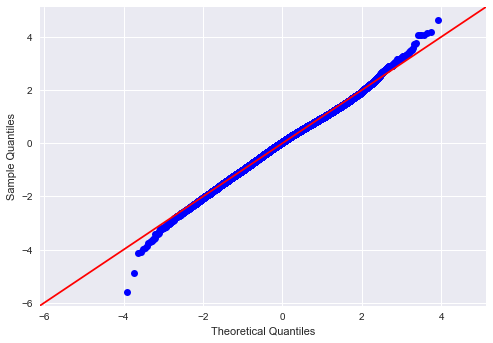

In [90]:
# Check back QQ Plot
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()
plt.savefig(fname='./images/normalized_qq_plot.png', facecolor='white')

In [ ]:
# This QQ Plot seems to be the most linear so far. This indicates both sets of quantiles
# come from the same distribution. 

# Interpretation of Model

In [ ]:
# It seems after modeling the data by removing coefficients with Pvalues 
# greater than 0.5 & high coerelated, removing outliers outside of 3 Standard
# Deviations, and logging + normalizing, that the best data to go off of is
# the baseline model since it had the best R-squared value of 0.681.

# Using the baselines OLS regression results,  the coefficients chosen to fit
# the business problem are:
# grade_6 Low Average, grade_5_fair, grade_3_poor, and view_None 
# Low average has a coefficient of -4.95 e+05
# view_None has a coeffiecient of -5.72 e+04
# Fair has a coefficient of -5.468e+05
# Grade poor has a coefficient of -5.672e+05
# Negative coefficients were chosen to reduce the total price of a home so 
# investors could flip it for a profit.